# AEWS Python Notebook 08h: AEWS miscellanea

**Author**: Eric Lehmann, CSIRO Data61  
**Date**:  July 13, 2016 (slight update: July 15, 2016)

**Note**: The Python code below is "rudimentary" etc. etc. Priority is here given to code interpretability rather than execution efficiency.

**Note**: this notebook should be accessible and viewable at [https://github.com/eric542/agdc_v2/tree/master/notebooks](https://github.com/eric542/agdc_v2/tree/master/notebooks).

## Summary

Building up on the concepts introduced in the previous notebooks in this series, we work out the remaining components of the AEWS implementation &mdash; see *'AEWS Python Notebook 08a'* for details of these components. The contents summary for the present notebook is given below.

**Abstract** &mdash; The temporal density of WQ observations can be increased if the AEWS is able to draw on the data from multiple satellites available in the AGDC database. Obvious candidates (and examples used in this notebook) are here the Landsat satellite series, but will also include Sentinel data in the near future. This notebook (08h) thus investigates ways of coding up the AEWS routines in a generic manner allowing for the combination and joint processing of several (existing and future) satellite data streams.


## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod 
```

**NOTE**: the specific module loaded here (`agdc-py2-prod`) is different from the module loaded in earlier notebooks (`agdc-py2-dev`)! While the earlier module contained only Landsat 5 data, the `agdc-py2-prod` module links to a (different) AGDC database containing the following NBART/NBAR/PQA datasets:

* Landsat 8: 2013
* Landsat 7: 2013
* Landsat 5: 2006/2007

It is unclear whether the API functions in these 2 modules are identical or represent different versions.

**NOTE 2**: as of mid-June 2016, changes were made to the AGDC API v2.0, and the above Landsat datasets (and related API functions) can now be accessed through the module `agdc-py2-prod/1.0.3` (pre-major-change version). How long this module will remain accessible and/or when it will be replaced with the formal v2.0 API is still unclear at this time (June 2016).

In [1]:
%%html  # Definitions for some pretty text boxes...
<style>
    div.warn { background-color: #e8c9c9; border: 1px solid #c27070; border-left: 6px solid #c27070; padding: 0.5em }
    div.note { background-color: #cce0ff; border: 1px solid #5c85d6; border-left: 6px solid #5c85d6; padding: 0.5em }
    div.info { background-color: #ffe680; border: 1px solid #cca300; border-left: 6px solid #cca300; padding: 0.5em }
</style>

In [2]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np

import ogr, gdal, osr
import xarray as xr

from pylab import rcParams
rcParams['figure.figsize'] = (10,10)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

from pprint import pprint
from __future__ import print_function

import datacube.api   # import the AGDC v2 API, with pre-loaded 'agds-py2-dev' (or similar) NCI module
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

def merge_dup_dates(xada):
    # Takes in an xarray.DataArray 'xada' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xada.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xada[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xada[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xada[dup_ind] = xada[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xada[dup_ind]) )
                    xada[dup_ind].values[tmp] = xada[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xada[ind]) )
                    xada[ind].values[tmp] = xada[dup_ind].values[tmp]
                    xada[dup_ind] = xada[ind]   # save results to lowest date index, in case >2 slices have same date
    
    return xada[~rem_ind]

## Checking data availability from several sensors

We'll use an example ROI defined in a previous notebook, namely the Wongalara lake in NSW. Also, we will here only focus on the basic (non-PQ-masked) WQ data, for simplicity.

In [3]:
lakes_file = '../NSW_lakes/NSW_WaterBody.shp'
lakes_vec = ogr.Open(lakes_file)
lakes_lyr = lakes_vec.GetLayer(0)

n_ftr = lakes_lyr.GetFeatureCount()
lname_list = list()
for kk in range( n_ftr ):
    ftr = lakes_lyr.GetFeature(kk)
    lname_list.append(ftr.GetField('hydroname'))

ftr = lname_list.index('WONGALARA')
lakes_ftr = lakes_lyr.GetFeature(ftr)
ring = lakes_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array = np.array(ring.GetPoints())[:,0:2]  # lon / lat coords of polygon

### Using "low-level" API functions

To work out what satellites are available in the ROI, we can simply query the AGDC database without using the 'platform' key entry:

In [4]:
dc = datacube.api.API()

In [5]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) } }
query = { 'product': 'nbar',
          # 'platform': 'LANDSAT_8',   # omit this in the query
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)

print( desc.keys() )

tmp = 'ls8_nbar_albers' in desc.keys()
if tmp: tmp2 = "({} dates)".format(desc['ls8_nbar_albers']['result_shape'][0])
print( "\nDo we have LS8 data?", tmp, tmp2 if tmp else "(0 dates)")

tmp = 'ls7_nbar_albers' in desc.keys()
if tmp: tmp2 = "({} dates)".format(desc['ls7_nbar_albers']['result_shape'][0])
print( "Do we have LS7 data?", tmp, tmp2 if tmp else "(0 dates)")

tmp = 'ls5_nbar_albers' in desc.keys()
if tmp: tmp2 = "({} dates)".format(desc['ls5_nbar_albers']['result_shape'][0])
print( "Do we have LS5 data?", tmp, tmp2 if tmp else "(0 dates)")

[u'ls7_nbar_albers', u'ls8_nbar_albers', u'ls5_nbar_albers']

Do we have LS8 data? True (112 dates)
Do we have LS7 data? True (155 dates)
Do we have LS5 data? True (119 dates)


Note however that we do need to specify the 'platform' field when actually loading up the data from the AGDC database. Using the low-level access function `get_data` for instance, we can see that the following works OK:

In [6]:
query = { 'product': 'nbar',
          'platform': 'LANDSAT_8',
          'dimensions': dimensions,
          'variables' : ['band_3', 'band_4'] }
sat_data = dc.get_data( query )

... while the same request without 'platform' field crashes:

In [7]:
query = { 'product': 'nbar',
          'dimensions': dimensions,
          'variables' : ['band_3', 'band_4'] }
sat_data = dc.get_data( query )

RuntimeError: Data must come from a single storage

Similarly, the use of "convenience" functions such as `get_data_array` does not work as expected if omitting the 'platform' information. For instance, the following works OK:

In [8]:
dc.get_data_array(product='nbar', platform='LANDSAT_8', 
                  x=(min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02), 
                  y=(max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02),
                  dimensions={'time': {'range': ((2013, 3, 1), (2013, 4, 15)) }})

<xarray.DataArray u'ls8_nbar_albers' (variable: 7, time: 7, y: 706, x: 561)>
dask.array<concate..., shape=(7, 7, 706, 561), dtype=float64, chunksize=(1, 1, 706, 561)>
Coordinates:
  * time      (time) datetime64[ns] 2013-03-26T00:09:17.140271 ...
  * y         (y) float64 -3.482e+06 -3.482e+06 -3.482e+06 -3.482e+06 ...
  * x         (x) float64 1.123e+06 1.123e+06 1.123e+06 1.123e+06 1.123e+06 ...
  * variable  (variable) <U6 u'band_1' u'band_2' u'band_3' u'band_4' ...

... while the same call without 'platform' entry, even if it doesn't crash, returns data from only one satellite (here seemingly LS7):

In [9]:
dc.get_data_array(product='nbar', 
                  x=(min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02), 
                  y=(max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02),
                  dimensions={'time': {'range': ((2013, 3, 1), (2013, 4, 15)) }})

<xarray.DataArray u'ls7_nbar_albers' (variable: 6, time: 18, y: 706, x: 561)>
dask.array<concate..., shape=(6, 18, 706, 561), dtype=float64, chunksize=(1, 1, 706, 561)>
Coordinates:
  * time      (time) datetime64[ns] 2013-03-06T00:09:58.071128 ...
  * y         (y) float64 -3.482e+06 -3.482e+06 -3.482e+06 -3.482e+06 ...
  * x         (x) float64 1.123e+06 1.123e+06 1.123e+06 1.123e+06 1.123e+06 ...
  * variable  (variable) <U6 u'band_1' u'band_2' u'band_3' u'band_4' ...

Consequently, in order to work out what sensors are available (for a given ROI and time window) with low-level API functions, we need to first query the database using `get_descriptor`, and subsequently load each dataset using either a low-level or convenience function, for each sensor separately.

### Using AE/EE

Here too, it seems unfeasible to query the database for _any_ satellite using the AE/EE interface. The following works:

In [10]:
ae = AnalyticsEngine()
ee = ExecutionEngine()

aeB2 = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'aeB2')   # "standard" query

ee.execute_plan(ae.plan)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


... while the same without satellite info crashes:

In [11]:
aeB2 = ae.create_array(('nbar'), ['band_3'], dimensions, 'aeB2')
ee.execute_plan(ae.plan)

IndexError: list index out of range

Note that the AGDC v2.0 development team has indicated that a AE/EE-specific function `ae.list_searchables()` would be available ultimately to query the available datasets using the AE/EE syntax (apparently not available at this stage, i.e. using the current AGDC module).

In [12]:
ae.list_searchables()

AttributeError: 'AnalyticsEngine' object has no attribute 'list_searchables'

So in summary, using the AE/EE to process the data at this stage still requires the use of the low-level function `get_descriptor` to get a list of available sensors.

## Loading up data from several sensors

So let's see how we can manage / integrate the data streams from the different sensors. Ideally, we would like to generate a single combined time series of WQ data, with some flag indicating whether the data in a particular time slice is from LS7 or LS8.

For illustration purpose, here we'll use a small temporal dataset of LS7 and LS8 data over the above ROI:

In [13]:
dimensions = { 'lon' : { 'range': ( min(poly_array[:,0])-0.02, max(poly_array[:,0])+0.02 ) },
               'lat' : { 'range': ( max(poly_array[:,1])+0.02, min(poly_array[:,1])-0.02 ) },
               'time': { 'range': ((2013, 3, 1), (2013, 4, 15)) } }
query = { 'product': 'nbar',
          # 'platform': 'LANDSAT_8',
          'dimensions': dimensions }
desc = dc.get_descriptor(query, include_storage_units=False)

print( desc.keys() )

tmp = 'ls8_nbar_albers' in desc.keys()
if tmp: tmp2 = "({} dates)".format(desc['ls8_nbar_albers']['result_shape'][0])
print( "\nDo we have LS8 data?", tmp, tmp2 if tmp else "(0 dates)")

tmp = 'ls7_nbar_albers' in desc.keys()
if tmp: tmp2 = "({} dates)".format(desc['ls7_nbar_albers']['result_shape'][0])
print( "Do we have LS7 data?", tmp, tmp2 if tmp else "(0 dates)")

tmp = 'ls5_nbar_albers' in desc.keys()
if tmp: tmp2 = "({} dates)".format(desc['ls5_nbar_albers']['result_shape'][0])
print( "Do we have LS5 data?", tmp, tmp2 if tmp else "(0 dates)")

[u'ls7_nbar_albers', u'ls8_nbar_albers']

Do we have LS8 data? True (7 dates)
Do we have LS7 data? True (18 dates)
Do we have LS5 data? False (0 dates)


To allow for future integration of new sensors, we'll attempt to make things as generic as possible here, avoiding direct references to specific satellites as much as we can. So we'll start by setting up some user-defined parameters regarding the desired datasets to be used for the AEWS. The rest of the code will use these parameters in a generic fashion, without having to deal with each sensor specifically. Note that these parameters will typically need to be derived from the specific API version / module ultimately used by the AEWS.

In [14]:
# Landsat 8 definitions:
sat_1 = { 'API_sat_str' : 'ls8_nbar_albers',  # satellite string for API queries
          'AE_sat_str' : 'LANDSAT_8',      # satellite string for AE/EE queries
          'AE_red_band_str' : 'band_4',    # red band index/string for AE/EE queries for this satellite
          'AE_green_band_str' : 'band_3' } # green band index/string for AE/EE queries for this satellite
          # ... include here other sensor-specific info, such as PQ bit numbers, etc.

# Landsat 7 definitions:
sat_2 = { 'API_sat_str' : 'ls7_nbar_albers',
          'AE_sat_str' : 'LANDSAT_7',
          'AE_red_band_str' : 'band_3',
          'AE_green_band_str' : 'band_2' }

# Landsat 5 definitions:
sat_3 = { 'API_sat_str' : 'ls5_nbar_albers',   # can define LS5 here, even though we don't have any LS5 data
          'AE_sat_str' : 'LANDSAT_5',
          'AE_red_band_str' : 'band_3',
          'AE_green_band_str' : 'band_2' }

# "Any other sensor" definitions:
sat_4 = { 'API_sat_str' : 'SNTL2_nbar_albers',  # some bogus information, for illustration
          'AE_sat_str' : 'SENTINEL_2',
          'AE_red_band_str' : 'band_11',
          'AE_green_band_str' : 'band_22' }

WQ_sats = { 'sat1': sat_1,   # dictionary of satellite defs to use for AEWS
            'sat2': sat_2,
            'sat3': sat_3,
            'sat4': sat_4 }

In [15]:
pprint( WQ_sats )

{'sat1': {'AE_green_band_str': 'band_3',
          'AE_red_band_str': 'band_4',
          'AE_sat_str': 'LANDSAT_8',
          'API_sat_str': 'ls8_nbar_albers'},
 'sat2': {'AE_green_band_str': 'band_2',
          'AE_red_band_str': 'band_3',
          'AE_sat_str': 'LANDSAT_7',
          'API_sat_str': 'ls7_nbar_albers'},
 'sat3': {'AE_green_band_str': 'band_2',
          'AE_red_band_str': 'band_3',
          'AE_sat_str': 'LANDSAT_5',
          'API_sat_str': 'ls5_nbar_albers'},
 'sat4': {'AE_green_band_str': 'band_22',
          'AE_red_band_str': 'band_11',
          'AE_sat_str': 'SENTINEL_2',
          'API_sat_str': 'SENTINEL2_nbar_albers'}}


We can now easily cycle through the satellites' list to determine whether data is currently available in the AGDC database:

In [16]:
n_sats = len(WQ_sats)

for kk in range(n_sats):
    tmp = WQ_sats.values()[kk]['API_sat_str'] 
    res = tmp in desc.keys()
    print( "AGDC database has '{}' data?".format(tmp), res)
    WQ_sats.values()[kk]['data_available'] = res   # update dictionary with data availability

AGDC database has 'ls8_nbar_albers' data? True
AGDC database has 'ls7_nbar_albers' data? True
AGDC database has 'ls5_nbar_albers' data? False
AGDC database has 'SENTINEL2_nbar_albers' data? False


So, automatically loading up the dataset for each sensor that has data available could work as follows:

CPU times: user 4min 16s, sys: 42.7 s, total: 4min 59s
Wall time: 4min 59s


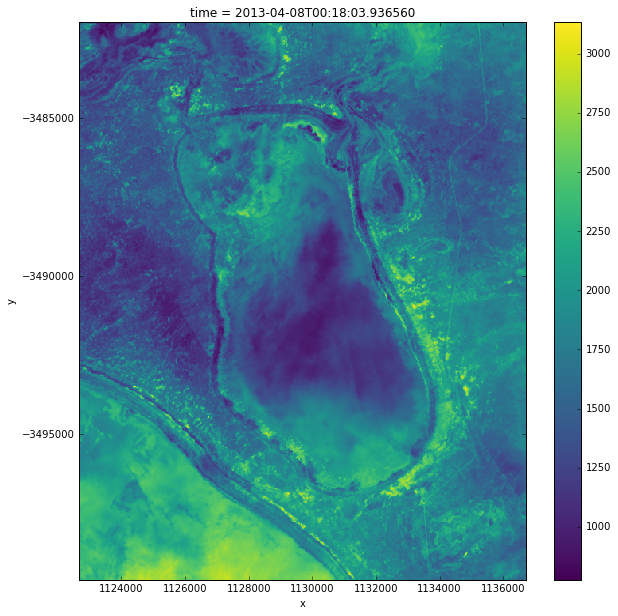

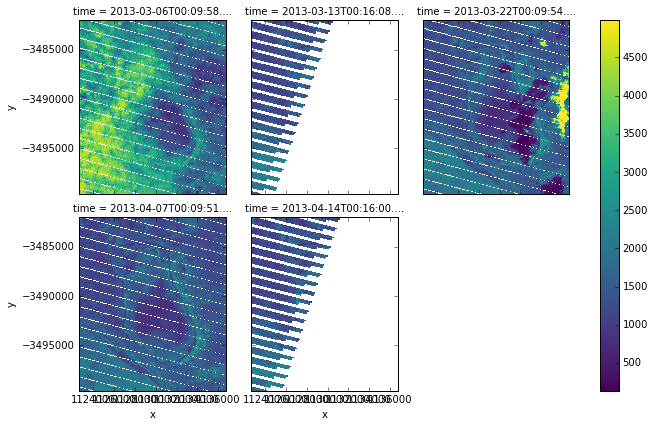

In [17]:
%%time
for kk in range(n_sats):
    if WQ_sats.values()[kk]['data_available']:
        sat = WQ_sats.values()[kk]['AE_sat_str']
        rbnd = WQ_sats.values()[kk]['AE_red_band_str']
        gbnd = WQ_sats.values()[kk]['AE_green_band_str']
        
        # load data using AE/EE:
        ae.plan = list()   # appears to be "resetting" the AE definitions...
        ae_green = ae.create_array((sat, 'nbar'), [gbnd], dimensions, 'ae_green')
        ae_red = ae.create_array((sat, 'nbar'), [rbnd], dimensions, 'ae_red')
        aePQ = ae.create_array((sat, 'pqa'), ['pixelquality'], dimensions, 'aePQ')
        aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
        ee.execute_plan(ae.plan)
        
        WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
        
        #### PQ masking of the WQ data can be inserted here! ...
        # PQ_xarray = ee.cache['aePQ']['array_result']['pixelquality']
        #  [...] 
        
        # merge duplicate dates and remove empty time slices:
        WQ_xarray = merge_dup_dates( WQ_xarray.load() )
        tmp = np.where( ( (~np.isnan(WQ_xarray)).sum('x').sum('y')!=0 ).values )[0]
        WQ_xarray = WQ_xarray[tmp]
        
        # simply display the data at this stage...
        if WQ_xarray.shape[0]==1: WQ_xarray.plot();
        else: WQ_xarray.plot(col='time',col_wrap=3);

As can be seen from the above code block, this operation (reading of 18 + 7 time slices of LS7 and LS8 data, for a relatively small ROI) here seems to be prohibitively time consuming. This issue will be investigated further in the next notebook (_AEWS Python Notebook 08i_).

Also, from the above code, a quick note in passing...  
<br>
<div class=note>
<b>NOTE:</b> merging duplicate dates, removing empty time slices, as well as PQ masking could lead to the time series having no remaining time slice. The AEWS routine will have to specifically deal with this scenario to avoid a code crash.
</div>

And in addition:  
<br>
<div class=note>
<b>NOTE:</b> the labels <span style="font-family: courier">'nbar'</span>, <span style="font-family: courier">'pqa'</span> and <span style="font-family: courier">'pixelquality'</span> in the piece of code above should be checked against the avaialble AGDC dataset (new versions of the API / database might use different labels). These labels could potentially also be included in the satellites' definitions if more appropriate.
</div>

Now, given our two datasets of WQ data, we would like to merge them and end up with a single time series. In our above example, we would like the LS8 time slice on 2013-04-08 to be "integrated" within the LS7 dataset at the appropriate place in the time series. 

Let's demonstrate this with our two example datasets of LS7 and LS8 data used above, re-defined here as two new `xarray` variables for convenience:

In [18]:
ae.plan = list()
ae_green = ae.create_array(('LANDSAT_8', 'nbar'), ['band_3'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_8', 'nbar'), ['band_4'], dimensions, 'ae_red')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)
WQ8_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
WQ8_xarray = merge_dup_dates( WQ8_xarray.load() )
tmp = np.where( ( (~np.isnan(WQ8_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ8_xarray = WQ8_xarray[tmp]

ae.plan = list()
ae_green = ae.create_array(('LANDSAT_7', 'nbar'), ['band_2'], dimensions, 'ae_green')
ae_red = ae.create_array(('LANDSAT_7', 'nbar'), ['band_3'], dimensions, 'ae_red')
aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
ee.execute_plan(ae.plan)
WQ7_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
WQ7_xarray = merge_dup_dates( WQ7_xarray.load() )
tmp = np.where( ( (~np.isnan(WQ7_xarray)).sum('x').sum('y')!=0 ).values )[0]
WQ7_xarray = WQ7_xarray[tmp]

The `concat` function from the `xarray` package allows us to easily concatenate (`xarray`) `DataArray`s along a given dimension (here, the `time` dimension). This function, however, does not seem to _sort_ the data along the specified dimension &mdash; the two datasets are simply merged one after the other, regardless of their respective dates along the `time` dimension. 

So we will have to manually work out the indices of the final time slices in the merged dataset, which can be done as follows:

In [19]:
n_dates8 = WQ8_xarray.shape[0]
n_dates7 = WQ7_xarray.shape[0]

# concatenate the dates:
concat_dates = np.concatenate( (WQ7_xarray['time'].values, WQ8_xarray['time'].values) )

# sensor ID corresponding to concatenated dates:
sat_id = np.ones(n_dates7+n_dates8)*2   # sat. #2: Landsat8
sat_id[:n_dates7] = 1   # sat. #1: Landsat7

# sort concatenated dates and corresponding IDs:
sort_res = np.argsort(concat_dates)
sat_id = sat_id[sort_res]

# indices of the two sensors in the resulting time series:
sat1_idx = np.where(sat_id==1)[0]
sat2_idx = np.where(sat_id==2)[0]

Now we can concatenate the data, using the indexing we've just worked out:

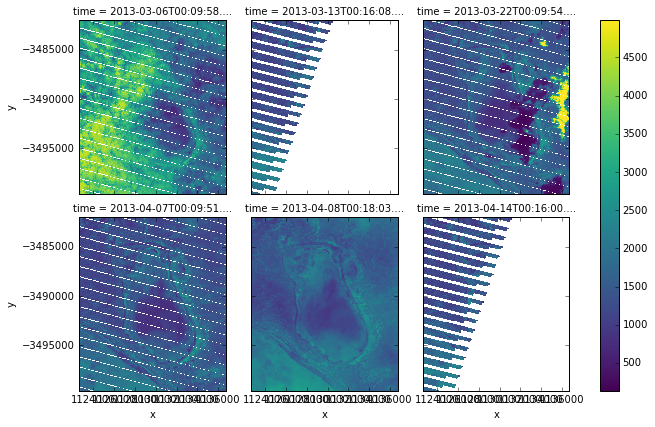

In [20]:
WQall_array = xr.concat( [WQ7_xarray, WQ8_xarray], dim='time', positions=[sat1_idx,sat2_idx] )
WQall_array.plot(col='time',col_wrap=3);

The slice of LS8 data has been correctly inserted in the time series at the second-last place.

And finally, we can also easily create a vector of flags identifying the sensor for each time slice in the resulting time series:

In [21]:
tmp = np.ones(n_dates7).astype('str'); tmp[:] = 'LS7'
tmp2 = np.ones(n_dates8).astype('str'); tmp2[:] = 'LS8'
tmp = np.concatenate( (tmp, tmp2) )
sat_flags = tmp[sort_res]

print( "The sensor for each date is:", sat_flags )

The sensor for each date is: ['LS7' 'LS7' 'LS7' 'LS7' 'LS8' 'LS7']


So to sum everything up, we can automatically create the merged time series as per the following code:

In [22]:
init_flag = True
for kk in range(n_sats):
    if WQ_sats.values()[kk]['data_available']:
        sat = WQ_sats.values()[kk]['AE_sat_str']
        rbnd = WQ_sats.values()[kk]['AE_red_band_str']
        gbnd = WQ_sats.values()[kk]['AE_green_band_str']
        
        # load data using AE/EE:
        ae.plan = list()   # appears to be "resetting" the AE definitions...
        ae_green = ae.create_array((sat, 'nbar'), [gbnd], dimensions, 'ae_green')
        ae_red = ae.create_array((sat, 'nbar'), [rbnd], dimensions, 'ae_red')
        aePQ = ae.create_array((sat, 'pqa'), ['pixelquality'], dimensions, 'aePQ')
        aeWQ = ae.apply_expression([ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ')
        ee.execute_plan(ae.plan)
        
        WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
        
        ### PQ masking of the WQ data can be inserted here! ...
        # PQ_xarray = ee.cache['aePQ']['array_result']['pixelquality']
        #  [...] 
        
        # merge duplicate dates and remove empty time slices:
        WQ_xarray = merge_dup_dates( WQ_xarray.load() )
        tmp = np.where( ( (~np.isnan(WQ_xarray)).sum('x').sum('y')!=0 ).values )[0]
        WQ_xarray = WQ_xarray[tmp]
        
        # concatenate dataset with existing time series:
        WQ_Ndates = WQ_xarray.shape[0]
        WQ_satflags = np.ones(WQ_Ndates).astype('str')
        WQ_satflags[:] = sat
        
        if init_flag:
            init_flag = False
            WQ_xarray_tot = WQ_xarray.copy()
            WQ_satflags_tot = WQ_satflags.copy()
        else:
            WQ_tot_Ndates = WQ_xarray_tot.shape[0]
            concat_dates = np.concatenate( (WQ_xarray_tot['time'].values, WQ_xarray['time'].values) )
            
            tmp = np.concatenate( (WQ_satflags_tot, WQ_satflags) )
            sort_res = np.argsort(concat_dates)
            WQ_satflags_tot = tmp[sort_res]

            sat1_idx = np.where(WQ_satflags_tot!=sat)[0]
            sat2_idx = np.where(WQ_satflags_tot==sat)[0]        
        
            WQ_xarray_tot = xr.concat( [WQ_xarray_tot, WQ_xarray], dim='time', positions=[sat1_idx,sat2_idx] )

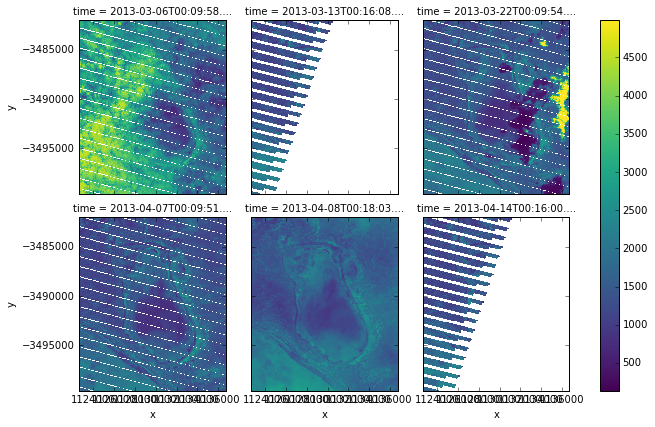

In [23]:
WQ_xarray_tot.plot(col='time',col_wrap=3);

In [24]:
print( "Sensors for each time slice:", WQ_satflags_tot )

Sensors for each time slice: ['LANDSAT_7' 'LANDSAT_7' 'LANDSAT_7' 'LANDSAT_7' 'LANDSAT_8' 'LANDSAT_7']
